In [1]:
import pandas as pd

In [2]:
import h5py 
import numpy as np
def import_tfmodisco_motifs(tfm_results_path, trim=True, only_pos=True):
    """
    Imports the PFMs to into a dictionary, mapping `(x, y)` to the PFM,
    where `x` is the metacluster index and `y` is the pattern index.
    Arguments:
        `tfm_results_path`: path to HDF5 containing TF-MoDISco results
        `out_dir`: where to save motifs
        `trim`: if True, trim the motif flanks based on information content
        `only_pos`: if True, only return motifs with positive contributions
    Returns the dictionary of PFMs.
    """ 
    pfms = {}
    with h5py.File(tfm_results_path, "r") as f:
        metaclusters = f["metacluster_idx_to_submetacluster_results"]
        num_metaclusters = len(metaclusters.keys())
        for metacluster_i, metacluster_key in enumerate(metaclusters.keys()):
            metacluster = metaclusters[metacluster_key]
            print(len(metacluster["seqlets"].value))
            if "patterns" not in metacluster["seqlets_to_patterns_result"]:
                continue
            patterns = metacluster["seqlets_to_patterns_result"]["patterns"]
            num_patterns = len(patterns["all_pattern_names"][:])
            for pattern_i, pattern_name in enumerate(patterns["all_pattern_names"][:]):
                pattern_name = pattern_name
                pattern = patterns[pattern_name]
                key = "metacluster_"+str(metacluster_i)+".pattern_"+str(pattern_i)
                
                if key not in pfms:
                    pfms[key] = []

                for seqlet in pattern["seqlets_and_alnmts"]["seqlets"]:
                    pfms[key].append(seqlet)
               
    return pfms

In [3]:
dttype = 'ATAC'
mode = "counts"
celltype="K562"
dttype1="ATAC_PE"
tfm_results_path = '/oak/stanford/groups/akundaje/projects/chrombpnet_paper_new/modisco_jun_30/modisco/'+dttype+'/'+celltype+'/modiscolite_crop_500_1M_seqs/modisco_results_allChroms_'+mode+'.hdf5'

pfms = import_tfmodisco_motifs(tfm_results_path)

/users/anusri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


151682


KeyboardInterrupt: 

In [ ]:
import pandas as pd
tomtom = pd.read_csv('/oak/stanford/groups/akundaje/projects/chrombpnet_paper_new/modisco_jun_30/modisco/'+dttype+'/'+celltype+'/modiscolite_crop_500_1M_seqs/'+ mode + ".tomtom.tsv", sep="\t", header=0)
tomtom

In [ ]:
bed="/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/"+dttype1+"/"+celltype+"/data/peaks_no_blacklist.bed"
bed = pd.read_csv(bed, sep="\t", header=None)
bed.head()
print(bed.shape)

In [ ]:
lists=[]
for key in pfms:
    print(key)
    if key in tomtom["Pattern"].values:
        match_name = tomtom[tomtom["Pattern"]==key]["Match_1"]
        keyd = key.split("_")[1].replace(".pattern","")+"_"+key.split("_")[-1]+"_"+match_name
        keyd = keyd.values[0]
        #print(keyd.values[0])
        for seqlet in pfms[key]:
            vals = seqlet.split(",")
            peak_id = int(vals[0].split(":")[1])
            ss = vals[1].split(":")[1]
            ee = vals[2].split(":")[1]
            blist = [bed.loc[peak_id,0], bed.loc[peak_id,1]+bed.loc[peak_id,9]-200+int(ss), bed.loc[peak_id,1]+bed.loc[peak_id,9]-200+int(ee), keyd]
            lists.append(blist)
    else:
        print(key)
            

In [ ]:
print(len(lists))
data = pd.DataFrame(lists)
print(data.head())

In [ ]:
data.to_csv("configs/modisco_hits_k562_atac_uncorrected.bed",sep="\t",index=False,header=False)


In [ ]:
modisco_hits = pd.read_csv("configs/atac_annotation/modisco_hits_k562_atac_uncorrected.bed", sep="\t", header=None)


In [2]:

# intersect tf_chip bed with merged peaks and resd it in


In [17]:
chip_regions = pd.read_csv("configs/atac_annotation/chip_in_bed.bed", sep="\t", header=None)


In [18]:
chip_regions.head()


0       1       2       3     4  5         6    7        8    9     10  \
0  chr1  796300  796320  HMBOX1   676  .  30.34099 -1.0  3.49986  265  chr1   
1  chr1  804912  804932     MYC   582  .  23.64960 -1.0  3.05845  218  chr1   
2  chr1  804914  804934     MAX  1000  .  50.35414 -1.0  5.01345   36  chr1   
3  chr1  804917  804937     MAX  1000  .  33.35023 -1.0  4.67248  175  chr1   
4  chr1  804919  804939     MNT  1000  .  68.15020 -1.0  3.98050  265  chr1   

       11      12  
0  796045  796575  
1  804704  805140  
2  804888  805063  
3  804752  805102  
4  804664  805194

In [19]:
modisco_hits.head()

0          1          2                          3
0   chr7  154676896  154676926  0_0_GATA4_HUMAN.H11MO.0.A
1  chr14  105378412  105378442  0_0_GATA4_HUMAN.H11MO.0.A
2  chr21   43884305   43884335  0_0_GATA4_HUMAN.H11MO.0.A
3   chr7  102290029  102290059  0_0_GATA4_HUMAN.H11MO.0.A
4   chr1   25272416   25272446  0_0_GATA4_HUMAN.H11MO.0.A

In [20]:
#chip_intersect = pd.read_csv("/oak/stanford/groups/akundaje/projects/chromatin-atlas-2022/chrombpnet/merged/GM12878/temp/in_chip_seq_peaks_full.bed", sep="\t", header=None)


In [21]:
#chip_intersect = chip_intersect.drop_duplicates()
#chip_intersect.head()


In [23]:
#motif_chip_count_matrix.shape
peaks = pd.read_csv("configs/atac_annotation/merged.bed",header=None,sep="\t")
total_bases = np.sum(peaks[2]-peaks[1])

total_bases

22409265

In [30]:
import scipy
import scipy.stats
import subprocess
import os
def compute_cooccurrence_pvals(modisco,chip,total_bases):
    """
    Given the number of motif hits in each peak, computes p-value of
    co-occurrence for each pair of motifs, including self pairs.
    Returns an M x N array of p-values for the M motifs.
    """
    
    motifs_to_chip = np.zeros((len(set(modisco[3])),len(set(chip[3]))))
    unique_motifs = list(set(modisco[3]))
    uniq_tfs = list(set(chip[3]))
    print(unique_motifs)
    
    unique_motifs = [i for i in unique_motifs if i is not np.nan]

    unique_motifs1 = [i for i in unique_motifs if int(i.split("_")[0]) == 0 ]
    unique_motifs2  = [i for i in unique_motifs if int(i.split("_")[0]) == 1]
    indxs1 = np.argsort([int(i.split("_")[1]) for i in unique_motifs1])
    indxs2 = np.argsort([int(i.split("_")[1]) for i in unique_motifs2])
    unique_motifs = list(np.array(unique_motifs1)[indxs1]) +  list(np.array(unique_motifs2)[indxs2])

    num_motifs = len(unique_motifs)
    num_chip = len(uniq_tfs)
    pvals = np.ones((num_motifs, num_chip))
    odds = np.ones((num_motifs, num_chip))

    print(num_motifs,num_chip)
    
    def merge_file(temp3,out_name):
        temp3.to_csv(out_name+".bed",sep="\t",header=False,index=False)
        
        with open(out_name+"_sorted.bed", "w") as f:
            proc = subprocess.Popen(["bedtools", "sort","-i",out_name+".bed"], stdout=f)
            proc.wait()
            
        with open(out_name+"_merged.bed", "w") as f:
            proc = subprocess.Popen(["bedtools", "merge","-i",out_name+"_sorted.bed"], stdout=f)
            proc.wait()
            
        temp3 = pd.read_csv(out_name+"_merged.bed",sep="\t",header=None)
        #print(temp3.shape)
        return temp3

    def intersect_file(out_name):
        
        with open(out_name+"_intersect.bed", "w") as f:
            proc = subprocess.Popen(["bedtools", "intersect","-a","temp_merged.bed", "-b", "temp1_merged.bed", "-wo"], stdout=f)
            proc.wait()
            
        if os.stat(out_name+"_intersect.bed").st_size == 0:
            return 0
        else:
            temp3 = pd.read_csv(out_name+"_intersect.bed",sep="\t",header=None)
            return np.sum(temp3[6])
        
    # Significance is based on a Fisher's exact test. If the motifs were
    # present in peaks randomly, we'd independence of occurrence.
    # For self-co-occurrence, the null model is not independence, but
    # collisions
    dicts = {}
    for i in range(num_motifs):
        temp3  = modisco[modisco[3]==unique_motifs[i]]
        temp3 =  merge_file(temp3,"temp")
        Xin = np.sum(temp3[2]-temp3[1])
        print(i)
        #print(Xin)

        for j in range(num_chip):
            
            #if uniq_tfs[j] not in dicts:
            temp3 = chip[chip[3]==uniq_tfs[j]]
            temp3 = merge_file(temp3,"temp1")
            Yin =  np.sum(temp3[2]-temp3[1])
                #print(Yin)
            dicts[uniq_tfs[j]] = Yin
            
            out_file = intersect_file("temp3")
            motif_chip=out_file
            #print(motif_chip)
        
            no_chip_only_motif = Xin - motif_chip
            no_motif_only_chip = dicts[uniq_tfs[j]] - motif_chip

            no_chip_no_motif = total_bases - no_chip_only_motif - no_motif_only_chip - motif_chip 

            # Contingency table (universe is set of all possible combination):
            #              no chip 1  |  has chip 1
            # no motif 2       A       |      B
            # -------------------------+--------------
            # has motif 2      C       |      D
            # The Fisher's exact test evaluates the significance of the
            # association between the two classifications
            cont_table = np.array([
                [
                    no_chip_no_motif,
                    no_motif_only_chip
                ],
                [
                   no_chip_only_motif,
                 motif_chip
                ]
            ])
            #print(uniq_tfs[j],cont_table)
            try:
                test_o = scipy.stats.fisher_exact(
                    cont_table, alternative="greater"
                )
                pval = test_o[1]
                odd = test_o[0]
            except:
                print(cont_table)
                print(motif_chip)
                print(Xin)
                print(Yin)
                print(uniq_tfs[j])
                print(unique_motifs[i])


            pvals[i, j] = pval
            odds[i,j] = odd
            
    return pvals, odds, unique_motifs,uniq_tfs 

motif_chip_pval_matrix, odds_ratio,unique_motifs,uniq_tfs  = compute_cooccurrence_pvals(modisco_hits,chip_regions,total_bases)



[nan, '0_10_SPIB_MOUSE.H11MO.0.A', '0_22_FLI1_ETS_3', '0_23_KLF5_MA0599.1', '0_16_NRF1_MA0506.1', '0_8_FOSL2+JUN_MA1131.1', '1_4_Z354A_HUMAN.H11MO.0.C', '1_0_CTCF_MA0139.1', '0_3_CTCF_MOUSE.H11MO.0.A', '0_18_STAT1_HUMAN.H11MO.0.A', '0_2_BACH2_MOUSE.H11MO.0.A', '0_4_ELK1_ETS_1', '0_14_ZN143_MOUSE.H11MO.0.A', '1_1_HIC2_C2H2_1', '0_6_NRF1_HUMAN.H11MO.0.A', '0_15_SP2_HUMAN.H11MO.0.A', '0_12_ATF4_MOUSE.H11MO.0.A', '0_13_NFIC_HUMAN.H11MO.0.A', '0_5_NFYB_HUMAN.H11MO.0.A', '1_5_SNAI1_HUMAN.H11MO.0.C', '0_19_ETV6_ETS_1', '1_2_REST_MA0138.2', '1_3_NFYB_MA0502.1', '1_8_NEUROD1_MA1109.1', '1_7_CTCFL_HUMAN.H11MO.0.A', '0_1_KLF12_HUMAN.H11MO.0.C', '0_0_GATA4_HUMAN.H11MO.0.A', '1_6_CTCFL_MOUSE.H11MO.0.A', '0_9_TAF1_HUMAN.H11MO.0.A', '0_21_SRY_MA0084.1', '0_17_TYY1_HUMAN.H11MO.0.A', '0_20_ZNF76_HUMAN.H11MO.0.C', '0_11_E2F2_HUMAN.H11MO.0.B', '0_7_NRF1_NRF_1']
33 461
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32


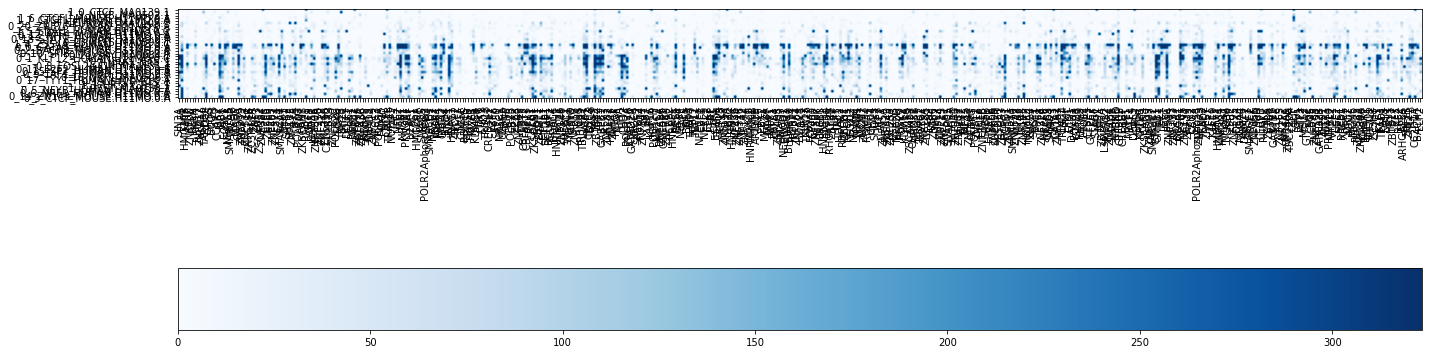

In [31]:
import sklearn.cluster
import scipy.cluster.hierarchy
import scipy.stats

def cluster_matrix_indices(matrix, num_clusters):
    """
    Clusters matrix using k-means. Always clusters on the first
    axis. Returns the indices needed to optimally order the matrix
    by clusters.
    """
    if len(matrix) == 1:
        # Don't cluster at all
        return np.array([0])

    num_clusters = min(num_clusters, len(matrix))
    
    # Perform k-means clustering
    kmeans = sklearn.cluster.KMeans(n_clusters=num_clusters)
    cluster_assignments = kmeans.fit_predict(matrix)

    # Perform hierarchical clustering on the cluster centers to determine optimal ordering
    kmeans_centers = kmeans.cluster_centers_
    cluster_order = scipy.cluster.hierarchy.leaves_list(
        scipy.cluster.hierarchy.optimal_leaf_ordering(
            scipy.cluster.hierarchy.linkage(kmeans_centers, method="centroid"), kmeans_centers
        )
    )

    # Order the peaks so that the cluster assignments follow the optimal ordering
    cluster_inds = []
    for cluster_id in cluster_order:
        cluster_inds.append(np.where(cluster_assignments == cluster_id)[0])
    cluster_inds = np.concatenate(cluster_inds)
    return cluster_inds

import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

# Create a figure with the right dimensions
fig, ax = plt.subplots(figsize=(20, 16))


 
inds = cluster_matrix_indices(motif_chip_pval_matrix,10)

zero_mask = motif_chip_pval_matrix == 0
min_val = np.min(motif_chip_pval_matrix[~zero_mask])
motif_chip_pval_matrix[zero_mask] = min_val
logpval_matrix = -np.log10(motif_chip_pval_matrix)
 

hmap = ax.imshow(logpval_matrix[inds], cmap="Blues")


# Set axes on heatmap
ax.set_yticks(np.arange(len(unique_motifs)))
ax.set_yticklabels(np.array(unique_motifs)[inds])
ax.set_xticks(np.arange(len(uniq_tfs)))
ax.set_xticklabels(np.array(uniq_tfs), rotation=90)

fig.colorbar(hmap, orientation="horizontal")

fig.tight_layout()
    

plt.show()

In [32]:
unique_motifs

from statsmodels.sandbox.stats.multicomp import multipletests


0_0_GATA4_HUMAN.H11MO.0.A
['GATA1' 'TAL1' 'TCF12' 'STAT5A' 'GATA2']
0_1_KLF12_HUMAN.H11MO.0.C
['XRCC4' 'SP1' 'CEBPZ' 'VEZF1' 'EGR1']
0_2_BACH2_MOUSE.H11MO.0.A
['NFE2L1' 'NFE2' 'MAFF' 'MAFG' 'MAFK']
0_3_CTCF_MOUSE.H11MO.0.A
['CTCF' 'RAD21' 'SMC3' 'CTCFL' 'ZNF143']
0_4_ELK1_ETS_1
['ELK1' 'ELF1' 'GABPA' 'GABPB1' 'TRIP13']
0_5_NFYB_HUMAN.H11MO.0.A
['NFYB' 'NFYA' 'FOS' 'CEBPZ' 'SP2']
0_6_NRF1_HUMAN.H11MO.0.A
['POU5F1' 'NRF1' 'ZBTB2' 'SMAD2' 'MEIS2']
0_7_NRF1_NRF_1
['POLR3G' 'NCOA2' 'GTF3C2' 'BMI1' 'ZNF146']
0_8_FOSL2+JUN_MA1131.1
['ATF2' 'KHSRP' 'RFX5' 'ZNF408' 'ZBTB12']
0_9_TAF1_HUMAN.H11MO.0.A
['SFPQ' 'BMI1' 'GTF2B' 'NELFE' 'RBM15']
0_10_SPIB_MOUSE.H11MO.0.A
['SPI1' 'CREBBP' 'ELF1' 'GABPB1' 'ELF4']
0_11_E2F2_HUMAN.H11MO.0.B
['ARHGAP35' 'CHD2' 'ZBTB33' 'ZHX1' 'POLR3G']
0_12_ATF4_MOUSE.H11MO.0.A
['DDIT3' 'CEBPG' 'ZSCAN32' 'ATF4' 'CEBPB']
0_13_NFIC_HUMAN.H11MO.0.A
['NFIX' 'NFIC' 'SMAD1' 'FOXA1' 'SREBF2']
0_14_ZN143_MOUSE.H11MO.0.A
['SUZ12' 'SIX5' 'SMAD2' 'HCFC1' 'POU5F1']
0_15_SP2_HUMAN.H11M

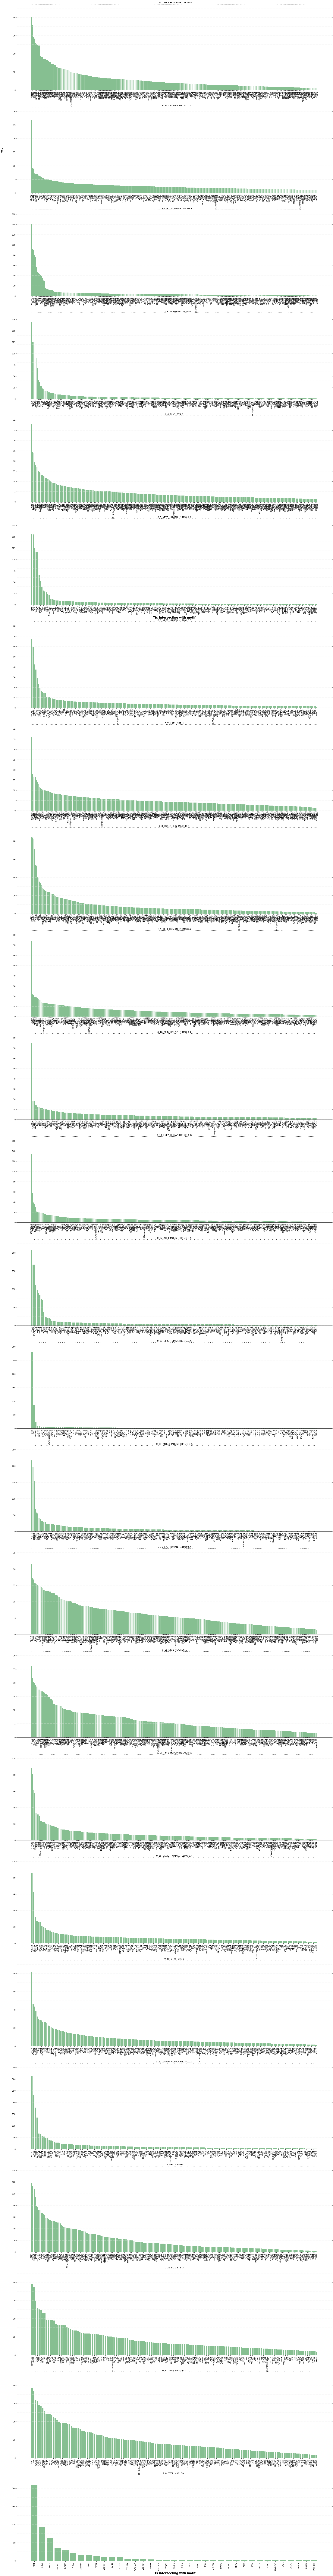

<Figure size 432x288 with 0 Axes>

In [36]:
fig, axs = plt.subplots(25,figsize=(30,250))
from matplotlib.ticker import StrMethodFormatter


for i in range(25):
    print(unique_motifs[i])
    p_adjusted = multipletests(motif_chip_pval_matrix[i,:], method='fdr_bh')
    idxs = np.argsort(odds_ratio[i,np.array(p_adjusted[0])])[::-1]
 
    ax = axs[i]
    tfs = np.array(uniq_tfs)[np.array(p_adjusted[0])][idxs]
    counts = odds_ratio[i,np.array(p_adjusted[0])][idxs]
    ax.bar(tfs, counts,color="#86bf91")
    ax.set_xticks(tfs,rotation='vertical')

    #ax.set_ylabel('odds ratio')
    #ax.set_ylabel('TFs significantly co-occuring with motif')

    ax.set_title(unique_motifs[i])

    print(np.array(uniq_tfs)[np.array(p_adjusted[0])][idxs][0:5])
    #print(odds_ratio[i,np.array(p_adjusted[0])][idxs][-5:])
    
for i,x in enumerate(axs):

    # Despine
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)

    # Switch off ticks
    x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    # Set x-axis label
    x.set_xlabel("Tfs intersecting with motif", weight='bold', size=15)

    # Set y-axis label
    if i == 1:
        x.set_ylabel("TFs", labelpad=50, weight='bold', size=12)

    # Format y-axis label
    x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

    x.tick_params(axis='x', rotation=90)
plt.show()
plt.tight_layout()

In [46]:
motif_chip_pval_matrix[1,:]

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       0.99999964, 1.        , 1.        , 1.        , 0.99999989,
       1.        , 1.        , 0.99999939, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.99999965,
       1.        , 0.99999987, 1.        , 1.        , 1.        ,
       1.        , 0.99999995, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.99999959, 1.        ,
       1.        , 1.        , 1.        , 0.99999994, 1.        ,
       0.99999962, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.99999998,
       1.        , 1.        , 0.99999972, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

In [53]:
unique_motifs

['0_0_IRF1_MOUSE.H11MO.0.A',
 '0_1_CTCF_MA0139.1',
 '0_2_SPIB_MOUSE.H11MO.0.A',
 '0_3_JDP2_MA0655.1',
 '0_4_RUNX3_HUMAN.H11MO.0.A',
 '0_5_RELB_HUMAN.H11MO.0.C',
 '0_6_Gabpa_MA0062.2',
 '0_7_SP1_HUMAN.H11MO.0.A',
 '0_8_REL_MA0101.1',
 '0_9_NFKB1_HUMAN.H11MO.1.B',
 '0_10_NFYB_HUMAN.H11MO.0.A',
 '0_11_ATF1_HUMAN.H11MO.0.B',
 '0_12_BATF_HUMAN.H11MO.0.A',
 '0_13_POU5F1_MA1115.1',
 '0_14_RUNX1_HUMAN.H11MO.0.A',
 '0_15_NRF1_MOUSE.H11MO.0.A',
 '0_16_PAX2_PAX_1',
 '0_17_ETS1_HUMAN.H11MO.0.A',
 '0_18_COE1_MOUSE.H11MO.0.A',
 '0_19_ZNF76_HUMAN.H11MO.0.C',
 '0_20_MEF2D_HUMAN.H11MO.0.A',
 '0_21_IRF9_IRF_1',
 '0_22_SPIB_ETS_1',
 '0_23_TYY1_HUMAN.H11MO.0.A',
 '0_24_MSX2_homeodomain_1',
 '0_25_HNF1B_HUMAN.H11MO.0.A',
 '0_26_ZBTB33_MA0527.1',
 '0_27_JUND_MA0492.1',
 '0_28_Rfx1_MA0509.1',
 '0_29_PAX5_MOUSE.H11MO.0.A',
 '0_30_BATF3_HUMAN.H11MO.0.B',
 '0_31_IRF7_HUMAN.H11MO.0.C',
 '0_32_ZNF384_MA1125.1',
 '0_33_IRF4_HUMAN.H11MO.0.A',
 '0_34_SP1_HUMAN.H11MO.0.A',
 '0_35_BATF+JUN_MA0462.1',
 '0_36_GLI2_C2H2_

In [18]:
data={}
data["pval"] = motif_chip_pval_matrix
data["odds"] = odds_ratio
data["motif_names"] = unique_motifs
data["tf_names"] = uniq_tfs

import pickle as pkl
ft = open("saving_pvals.pkl","wb")
pkl.dump(data,ft)